In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Установим графику в формате SVG (она более четкая и разборчивая)
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")

# Установим размер графика и цветовую схему
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

In [2]:
# Путь до файла
path_to_file = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-pjatakova/Module_8/Lesson_4/RFM_ht_data.csv'

In [3]:
# Считываем файл
df = pd.read_csv(path_to_file, sep=',')
df

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00
...,...,...,...,...
332725,S0081810310459,14092500,2020-09-30,3801.87
332726,S0081810310461,99065678,2020-09-30,5769.88
332727,S0081810310462,19029918,2020-09-30,736.88
332728,S0081810310463,13020033,2020-09-30,1475.20


<h3>START. Предварительная обработка данных

In [4]:
df.dtypes

InvoiceNo        object
CustomerCode     object
InvoiceDate      object
Amount          float64
dtype: object

In [5]:
df['InvoiceNo'] = df['InvoiceNo'].astype( str )

In [6]:
df['CustomerCode'] = df['CustomerCode'].astype( str )

In [7]:
df.dtypes

InvoiceNo        object
CustomerCode     object
InvoiceDate      object
Amount          float64
dtype: object

<h3>1. Какое максимальное кол-во покупок было совершено одним пользователем?

In [8]:
df.groupby('CustomerCode', as_index=False)\
    .agg({'InvoiceNo': 'count'})\
    .sort_values('InvoiceNo', ascending=False)

,CustomerCode,InvoiceNo
89388,19057820,204
44594,13215452,113
10347,13032521,106
97077,19080880,99
119951,99003061,90
...,...,...
58910,13272861,1
58911,13272871,1
58913,13272875,1
58914,13272878,1


**Вывод:** максимальное количество покупок на одного пользователя равно **204**

<h3> 2. Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М? (Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс в подсегменте М)

In [9]:
df.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [10]:
# Изменим формат колонки InvoiceDate в datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [11]:
df.dtypes

InvoiceNo               object
CustomerCode            object
InvoiceDate     datetime64[ns]
Amount                 float64
dtype: object

In [12]:
df.shape[0]

332730

In [13]:
df.InvoiceDate.describe()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  332730
unique                     30
top       2020-09-30 00:00:00
freq                    19781
first     2020-09-01 00:00:00
last      2020-09-30 00:00:00
Name: InvoiceDate, dtype: object

In [14]:
# От этой даты мы будем отсчитывать, сколько дней прошло у пользователя с момента последней покупки
last_date = df.InvoiceDate.max()
last_date

Timestamp('2020-09-30 00:00:00')

In [15]:
rfmTable = df.groupby('CustomerCode').agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency #Количество дней с последнего заказа
                                        'InvoiceNo': lambda x: len(x),      # Frequency #Количество заказов
                                        'Amount': lambda x: x.sum()}) # Monetary Value #Общая сумма по всем заказам

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)

In [16]:
rfmTable

,recency,frequency,monetary_value
CustomerCode,,,
02213019,19,1,1609.20
02213042,22,3,9685.48
02213071,29,1,415.00
02213088,23,1,305.00
02213092,25,1,1412.88
...,...,...,...
99099927,10,1,961.10
99099936,0,1,1521.78
99099959,8,2,1444.56


In [17]:
df.CustomerCode.nunique()

123733

In [18]:
quantiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])
quantiles

,recency,frequency,monetary_value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [19]:
rfmSegmentation = rfmTable

In [20]:
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [21]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str)                             + rfmSegmentation.F_Quartile.map(str)                             + rfmSegmentation.M_Quartile.map(str)

In [22]:
rfmSegmentation

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
02213019,19,1,1609.20,4,4,3,443
02213042,22,3,9685.48,4,2,1,421
02213071,29,1,415.00,4,4,4,444
02213088,23,1,305.00,4,4,4,444
02213092,25,1,1412.88,4,4,3,443
...,...,...,...,...,...,...,...
99099927,10,1,961.10,3,4,3,343
99099936,0,1,1521.78,1,4,3,143
99099959,8,2,1444.56,2,3,3,233


In [23]:
# Верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М
rfmSegmentation.query('M_Quartile == 4').monetary_value.max()

765.0

**Вывод:** верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М составляет **765**

<h3>3. Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?

In [24]:
rfmSegmentation

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
02213019,19,1,1609.20,4,4,3,443
02213042,22,3,9685.48,4,2,1,421
02213071,29,1,415.00,4,4,4,444
02213088,23,1,305.00,4,4,4,444
02213092,25,1,1412.88,4,4,3,443
...,...,...,...,...,...,...,...
99099927,10,1,961.10,3,4,3,343
99099936,0,1,1521.78,1,4,3,143
99099959,8,2,1444.56,2,3,3,233


In [25]:
rfmSegmentation.query('F_Quartile == 1').frequency.min()

4

**Вывод:** нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F равна **4**

<h3>4. Какое максимальное количество дней может пройти с момента последней покупки для того, чтобы пользователь попал в класс 2 в подсегменте R?

In [26]:
rfmSegmentation.query('R_Quartile == 2').recency.max()

8

<h3>5. Сколько пользователей попало в сегмент 111?

In [27]:
clasters = rfmSegmentation.groupby('RFMClass', as_index = False).agg({'recency':'count'}).sort_values('recency') \
           .rename(columns = {'recency': 'amount_of_customers'})
clasters.sort_values('amount_of_customers', ascending = False)

,RFMClass,amount_of_customers
63,444,10624
0,111,9705
62,443,6729
47,344,6593
16,211,5847
...,...,...
55,424,63
3,114,60
19,214,60
35,314,33


**Вывод:** в сегмент 111 попало **9705** пользователей

<h3>6. Сколько пользователей попало в сегмент 311?

In [28]:
clasters.dtypes

RFMClass               object
amount_of_customers     int64
dtype: object

In [29]:
clasters.query("RFMClass == '311'")

,RFMClass,amount_of_customers
32,311,1609


**Вывод:** в сегмент 311 попало **1609** пользователей

<h3>7. В каком RFM-сегменте самое большое кол-во пользователей?

In [30]:
#444
clasters.amount_of_customers.max()

10624

**Вывод:** самое большое количество пользователей в сегменте **444** 

<h3>8. В каком RFM-сегменте самое маленькое кол-во пользователей?

In [31]:
#414
clasters.amount_of_customers.min()

2

**Вывод:** самое маленькое количество пользователей в сегменте **414** 

<h3>9. Какое количество пользователей попало в самый малочисленный сегмент?

In [32]:
clasters.amount_of_customers.min()

2

**Вывод:** в самом малочисленном сегменте **2** пользователя

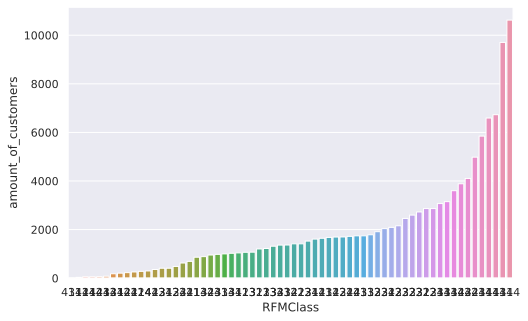

In [33]:
#Построим график
sns.barplot(x='RFMClass', y='amount_of_customers', data = clasters)

In [34]:
pd.crosstab(index = rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)

F_Quartile,1,2,3,4
R_Quartile,,,,
1,14433,4671,5795,6074
2,9634,5889,8633,10399
3,3091,3748,7734,13263
4,542,1311,5415,23101


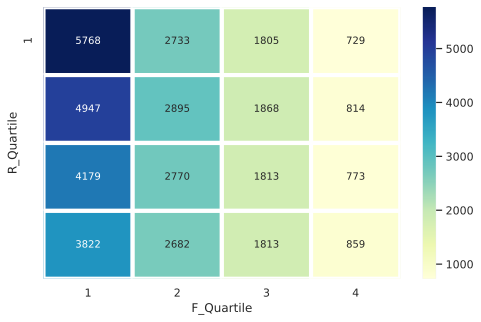

In [35]:
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);